# Exploratory Data Analysis

## ODK 38 (ATT Decommissioning Report)

## Descripción

Analizaremos los datos de la fuente **ODK 38** que corresponde a los datos de salida de almacén, proveedor y códigos de sitio destino de los elementos de red gestionados en inventario, con un tratamiento estadístico descriptivo para la exploración, explotación y descubrimiento de los datos para un correcto tracking del ciclo de vida de los elementos de red. 

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [3]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [4]:
conf = SparkConf().setAppName('ODK_38')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")  \
    .set("spark.kryoserializer.buffer.mb","128").set("spark.yarn.executor.memoryOverhead","409")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re


import nltk
from nltk.probability import FreqDist
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading BokehJS ...

## ODK 38
### 1. Recolección de los datos: 

Se crea el dataframe de spark con el universo de datos crudos.

In [6]:
df_load103775 = spark.sql("SELECT * FROM default.tx_stg_06_tabular_odk_38 WHERE id_form=='103775'").cache()

In [7]:
df_load=df_load103775.toPandas()

In [ ]:
df_load91523 = spark.sql("SELECT * FROM default.tx_stg_06_tabular_odk_38 WHERE id_form=='91523'").cache()

In [ ]:
df_load=df_load91523.toPandas()

In [ ]:
df_load114548 = spark.sql("SELECT * FROM default.tx_stg_06_tabular_odk_38 WHERE id_form=='114548'").cache()

In [ ]:
df_load=df_load114548.toPandas() 

In [ ]:
df_load104872 = spark.sql("SELECT * FROM default.tx_stg_06_tabular_odk_38 WHERE id_form=='104872'").cache()

In [ ]:
df_load=df_load104872.toPandas()

In [28]:
df_load_all = spark.sql("SELECT * FROM default.tx_stg_06_tabular_odk_38").cache()

In [29]:
df_load=df_load_all.toPandas()

Para las fuentes de los ODK's nos interesa conocer todos los elementos en sitio, por lo que haremos una limpieza en los campos que contengan características de los mismos.
Creamos una funcion para el tratamiento del campo de sitio en spark el cual contiene ciertas reglas definidas para su limpieza.

Hemos recolectado los campos a analizar de la fuente **odk 38**.

### Una muestra del ODK 38:

In [30]:
df=df_load.copy()
#df=df.loc[df.exist==True] #Sólamente se usa en caso de querer filtrar el universo limpio en el campo TipoElemento_key
df.head(10)

,id_form,clave_form,element_group,element,exist,TipoElemento_key,TipoElemento_value
0,100034,DECOR,groupMtlVwGrp-2,groupMtlVwGrp-2,True,Vista de materiales,1516807258622.jpg (image/jpeg)
1,100834,DECOR,groupMtlVwGrp-19,groupMtlVwGrp-19,True,Vista de materiales,1517463521051.jpg (image/jpeg)
2,100841,DECOR,groupMtlVwGrp-4,groupMtlVwGrp-4,True,Vista de materiales,1517499517764.jpg (image/jpeg)
3,100884,DECOR,groupMtlVwGrp-20,groupMtlVwGrp-20,True,Vista de materiales,1517600581923.jpg (image/jpeg)
4,100884,DECOR,groupMtlVwGrp-5,groupMtlVwGrp-5,True,Vista de materiales,1517599751080.jpg (image/jpeg)
5,100925,DECOR,groupMtlVwGrp-7,groupMtlVwGrp-7,True,Vista de materiales,1517496281723.jpg (image/jpeg)
6,101306,DECOR,groupMtlVwGrp-3,groupMtlVwGrp-3,True,Vista de materiales,1518235394537.jpg (image/jpeg)
7,101568,DECOR,groupMtlVwGrp-14,groupMtlVwGrp-14,True,Vista de materiales,1518746589523.jpg (image/jpeg)
8,101574,DECOR,groupMtlVwGrp-1,groupMtlVwGrp-1,True,Vista de materiales,1518747796845.jpg (image/jpeg)
9,101582,DECOR,groupMtlVwGrp-0,groupMtlVwGrp-0,True,Vista de materiales,1518756878961.jpg (image/jpeg)


### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [31]:
print 'renglones = ',df.shape[0],' columnas = ',df.shape[1]

renglones =  544634  columnas =  7


#### Una breve descripción de los campos:
* **id_form**: Número de formulario en *Panda*.
* **clave_form**: Clave de identificación del ODK.
* **element_group**: Element group.
* **element**: Hijo del element group.
* **exist**: Campo diseñado durante la extracción de los datos para identificar que el campo buscado se encuentra existente.
* **TipoElemento_key**: Nombre del campo.
* **TipoElemento_value**: Atributo del campo.

Con la transformación que se llevo a cabo previamente, los campos id_form, clave_form, element_group, element, exist sirven para tener un control y mejor manejo del odk. Los campos TipoElemento_key y TipoElemento_value son los que se utilizarán para sacar indicadores.

### 3. Exploración de los datos.
De acuerdo al análisis anterior, procederemos a observar algunos detalles de la fuente:

In [32]:
print 'Los atributos priority que encontramos en este ODK en los distintos element groups son:'
Freq_Atributos=pd.DataFrame(df.TipoElemento_key.value_counts())
Freq_Atributos

Los atributos priority que encontramos en este ODK en los distintos element groups son:


,TipoElemento_key
Descripción u observaciones,102875
Número de serie (manual),63293
Vista de materiales,61190
Tipo de Material,60967
Número de activo(manual),28317
Número de activo,25205
Marca,24141
Tipo de elemento,23117
Modelo,23073
Equipos electrónicos,12925


Text(0.5,0,'Atributos')

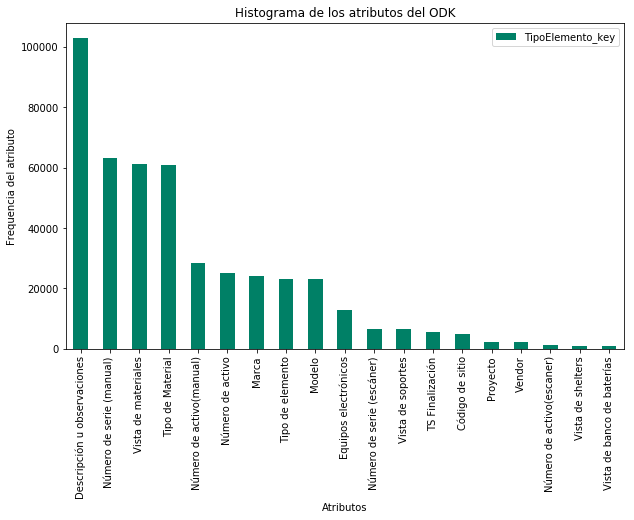

In [33]:
Freq_Atributos.plot(kind='bar',figsize=(10,6),rot=90,colormap='summer')

plt.title('Histograma de los atributos del ODK')
plt.ylabel('Frequencia del atributo')
plt.xlabel('Atributos')

#### Se hará una limpieza para homologar los campos de serie y activo:

In [34]:
stoppers=[u'numero de',u'escaner',u'manual']
df['TipoElemento_Key_Clean']=df.TipoElemento_key

df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.lower()
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.replace("\)",'')
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.replace("\(",'')
df.TipoElemento_Key_Clean.replace(u'á',u'a',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'é',u'e',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'í',u'i',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'ó',u'o',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'ú',u'u',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(u'ú',u'u',regex=True,inplace=True)
df.TipoElemento_Key_Clean.replace(stoppers,u'',regex=True,inplace=True)
df.TipoElemento_Key_Clean=df.TipoElemento_Key_Clean.str.strip()

#### Después de haber pasado una limpieza, podemos tener homologados los campos:

In [35]:
pd.DataFrame(df.TipoElemento_Key_Clean.value_counts())

,TipoElemento_Key_Clean
descripcion u observaciones,102875
serie,69966
vista de materiales,61190
tipo de material,60967
activo,54677
marca,24141
tipo de elemento,23117
modelo,23073
equipos electronicos,12925
vista de soportes,6411


In [36]:
pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='serie'].describe())

,TipoElemento_value
count,69966
unique,28042
top,No visible
freq,18048


In [37]:
pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='activo'].describe())

,TipoElemento_value
count,52231
unique,11125
top,No visible
freq,16034


#### Campo *marca*

In [38]:
Cat_marca=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='marca']).drop_duplicates().reset_index(drop=True)
Cat_marca.head(10)

,TipoElemento_value
0,OTH
1,ADW
2,HWI
3,ECS
4,MOTO
5,Huawei
6,Motorola
7,ADC
8,No visible
9,Harris


Podemos encontrar un campo no homologado. Se hará un esfuerzo para limpiar el campo y crear un catálogo.

In [39]:
dirt=['no visible','n/v','nv','ilegible','n/a','na','no legible',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','No visble','no visble',
      'No viaible','noisible','no aplica','n /v','finizar','no bisible','finisar','finsar','ftlfpbnl']
nums=['1','2','3','4','5','6','7','8','9','0']

Cat_marca.TipoElemento_value=Cat_marca.TipoElemento_value.str.lower()
Cat_marca.TipoElemento_value=Cat_marca.TipoElemento_value.str.replace('.','')
Cat_marca.TipoElemento_value=Cat_marca.TipoElemento_value.str.strip()
Cat_marca.replace(r'^\s*$', np.NaN, regex=True,inplace=True)
Cat_marca.replace(u'inc','',regex=True,inplace=True)
Cat_marca.replace(dirt,'',regex=True,inplace=True)
Cat_marca.replace(nums,'',regex=True,inplace=True)
Cat_marca.dropna(inplace=True)
Cat_marca.TipoElemento_value.drop_duplicates(inplace=True)
Cat_marca.reset_index(drop=True,inplace=True)
Cat_marca=Cat_marca.loc[(Cat_marca.TipoElemento_value.str.len()>2)]
Cat_marca.reset_index(drop=True,inplace=True)
Cat_marca.head(10)

,TipoElemento_value
0,oth
1,adw
2,hwi
3,ecs
4,moto
5,huawei
6,motorola
7,adc
8,harris
9,huawei


In [40]:
fdist=FreqDist(Cat_marca.TipoElemento_value)
fdist.most_common(100)

[(u'huawei', 5),
 (u'alcatel', 5),
 (u'adc', 4),
 (u'motorola', 4),
 (u'cisco', 4),
 (u'nec', 4),
 (u'dekolink', 4),
 (u'harris', 4),
 (u'trimm', 4),
 (u'power worx', 3),
 (u'nec pasolink', 3),
 (u'huawey', 3),
 (u'tellabs', 3),
 (u'hubbell', 3),
 (u'telect', 3),
 (u'powerworx', 3),
 (u'ericsson', 3),
 (u'avago', 3),
 (u'trimm ', 3),
 (u'ceragon', 3),
 (u'elisra', 2),
 (u'mini-link', 2),
 (u'apex', 2),
 (u'fnisar', 2),
 (u'vapel', 2),
 (u'dsx', 2),
 (u'alcatel lucent', 2),
 (u'square', 2),
 (u'apex series', 2),
 (u'bard', 2),
 (u'esquardi', 2),
 (u'teltec', 2),
 (u'fiber', 2),
 (u'atel', 2),
 (u'square d', 2),
 (u'lorain', 2),
 (u'bticino', 2),
 (u'cti', 2),
 (u'ftlfpbnl-hw', 2),
 (u'ericksson', 2),
 (u'bbu', 2),
 (u'stahlin', 2),
 (u'allied telesyn', 2),
 (u'andrew', 2),
 (u'alcatel-lucent', 2),
 (u'jdsu g', 2),
 (u'emerson', 2),
 (u'dxr', 2),
 (u'huwei', 2),
 (u'nera', 2),
 (u'harrys', 2),
 (u'bdcom', 2),
 (u'ericson', 2),
 (u'jdsu', 2),
 (u'telcet', 2),
 (u'telet', 2),
 (u'telec', 2

In [41]:
len(fdist)

291

In [42]:
Clean_marca=[v for v,k in fdist.items() if k>2]
Clean_marca.append('ibm')
Clean_marca.append('vectronic')
Clean_marca.append('tecno strobe')
Clean_marca.remove(u'huawey')
Clean_marca

[u'power worx',
 u'adc',
 u'nec pasolink',
 u'motorola',
 u'cisco',
 u'nec',
 u'huawei',
 u'tellabs',
 u'dekolink',
 u'hubbell',
 u'telect',
 u'powerworx',
 u'ericsson',
 u'avago',
 u'trimm ',
 u'harris',
 u'trimm',
 u'alcatel',
 u'ceragon',
 'ibm',
 'vectronic',
 'tecno strobe']

In [43]:
Cat_marca['Clean']=1
for v in range(0,Cat_marca.shape[0]):
    Cat_marca.Clean[v]=process.extractOne(Cat_marca.TipoElemento_value[v],
                                            Clean_marca,
                                            scorer=fuzz.partial_ratio,
                                            score_cutoff=67)
    if Cat_marca.Clean[v] is None:
        Cat_marca.Clean[v]=Cat_marca.TipoElemento_value[v]
    else:
        Cat_marca.Clean[v]=Cat_marca.Clean[v][0]

Cat_marca.head(15)

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,TipoElemento_value,Clean
0,oth,motorola
1,adw,adc
2,hwi,huawei
3,ecs,nec
4,moto,motorola
5,huawei,huawei
6,motorola,motorola
7,adc,adc
8,harris,harris
9,huawei,huawei


Mostramos los primeros registros del catálogo terminado:

In [44]:
Cat_marca.drop(columns=['TipoElemento_value'],inplace=True)
Cat_marca.columns=['Atributos']
Cat_marca.drop_duplicates(inplace=True)
Cat_marca.head(10)

,Atributos
0,motorola
1,adc
2,huawei
3,nec
8,harris
11,alcatel
13,nec pasolink
16,telect
19,ericsson
20,lorain


#### Campo *modelo*

In [45]:
Cat_modelo=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='modelo']).drop_duplicates().reset_index(drop=True)
Cat_modelo.head(10)

,TipoElemento_value
0,Andrew
1,No visible
2,N/V
3,Nv
4,DB844H65-XY
5,Na
6,1200
7,HBX-6516DS-VTM
8,NV
9,no visible


Se hará limpieza sobre el campo.  
Podrá encontrarse el catálogo en el apartado **Catálogos**.

#### Campo *tipo de elemento*

In [46]:
Cat_tipo_elem=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='tipo de elemento']).drop_duplicates().reset_index(drop=True)
Cat_tipo_elem

,TipoElemento_value
0,AMW
1,ARF
2,RRU
3,ODU
4,SCLL
5,IDU
6,ACOP
7,BR
8,DSX
9,OTH


No se hará limpieza sobre el campo, se encuentra en buen estado.  
Podrá encontrarse el catálogo en el apartado **Catálogos**.

#### Hacemos más limpieza para poder eliminar basura.
Esta limpieza se sigue tomando del catálogo que se encuentra en Hive *regex_cat_cleanup*.

In [47]:
dirt=['no visible','n/v','nv','ilegible','n/a','na','no legible',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','No visble','no visble',
      'No viaible','noisible','no aplica','n /v','finizar','no bisible','finisar','finsar','ftlfpbnl']

df.TipoElemento_value=df.TipoElemento_value.str.lower()
df.TipoElemento_value.replace(dirt,np.NaN,regex=True,inplace=True)
df.TipoElemento_value=df.TipoElemento_value.str.strip()

#### Se ha podido notar que el campo **marca** contiene registros sucios que pertenecen al catálogo de *Tipos de elementos*.
Haremos un proceso de limpieza para poder eliminar estos registros.

In [48]:
elementos=list(Cat_tipo_elem.TipoElemento_value.str.lower())
Cat_marca.replace(elementos,np.NaN,regex=True,inplace=True)
Cat_marca.head(10)

,Atributos
0,motorola
1,adc
2,huawei
3,nec
8,harris
11,alcatel
13,nec pasolink
16,telect
19,ericsson
20,lorain


Crearemos una bandera para los atributos de trazabilidad.

In [49]:
df['Trazabilidad']='No Trazable'

df['Trazabilidad'].loc[((df.TipoElemento_Key_Clean=='serie') | 
                        (df.TipoElemento_Key_Clean=='activo')) & 
                       (df.TipoElemento_value is not np.NaN)
                      ]='Trazable'

In [50]:
df.head(20)

,id_form,clave_form,element_group,element,exist,TipoElemento_key,TipoElemento_value,TipoElemento_Key_Clean,Trazabilidad
0,100034,DECOR,groupMtlVwGrp-2,groupMtlVwGrp-2,True,Vista de materiales,1516807258622.jpg (image/jpeg),vista de materiales,No Trazable
1,100834,DECOR,groupMtlVwGrp-19,groupMtlVwGrp-19,True,Vista de materiales,1517463521051.jpg (image/jpeg),vista de materiales,No Trazable
2,100841,DECOR,groupMtlVwGrp-4,groupMtlVwGrp-4,True,Vista de materiales,1517499517764.jpg (image/jpeg),vista de materiales,No Trazable
3,100884,DECOR,groupMtlVwGrp-20,groupMtlVwGrp-20,True,Vista de materiales,1517600581923.jpg (image/jpeg),vista de materiales,No Trazable
4,100884,DECOR,groupMtlVwGrp-5,groupMtlVwGrp-5,True,Vista de materiales,1517599751080.jpg (image/jpeg),vista de materiales,No Trazable
5,100925,DECOR,groupMtlVwGrp-7,groupMtlVwGrp-7,True,Vista de materiales,1517496281723.jpg (image/jpeg),vista de materiales,No Trazable
6,101306,DECOR,groupMtlVwGrp-3,groupMtlVwGrp-3,True,Vista de materiales,1518235394537.jpg (image/jpeg),vista de materiales,No Trazable
7,101568,DECOR,groupMtlVwGrp-14,groupMtlVwGrp-14,True,Vista de materiales,1518746589523.jpg (image/jpeg),vista de materiales,No Trazable
8,101574,DECOR,groupMtlVwGrp-1,groupMtlVwGrp-1,True,Vista de materiales,1518747796845.jpg (image/jpeg),vista de materiales,No Trazable
9,101582,DECOR,groupMtlVwGrp-0,groupMtlVwGrp-0,True,Vista de materiales,1518756878961.jpg (image/jpeg),vista de materiales,No Trazable


### 4. Calidad de los datos.
En el parseo de nuestra fuente de ODK se creo el campo de *exist* que corresponde a la limpieza de los atributos que se encuentran en el formulario, con esto eliminando missing values.

### 5. Catálogos.
Se enlistan los catálogos que surgieron de la exploración. 

#### Catálogo Marca

Se muestran los primeros 10 registros:

In [51]:
Cat_marca.head(10)

,Atributos
0,motorola
1,adc
2,huawei
3,nec
8,harris
11,alcatel
13,nec pasolink
16,telect
19,ericsson
20,lorain


#### Catálogo Modelo

In [52]:
Cat_modelo=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='modelo']).drop_duplicates().reset_index(drop=True)
Cat_modelo.dropna(inplace=True)
Cat_modelo.reset_index(drop=True)
Cat_modelo.head(10)

,TipoElemento_value
0,andrew
2,db844h65-xy
3,1200
4,hbx-6516ds-vtm
5,radwin2000
6,smartax ma5669
7,adu451801
8,xxx
9,vhp2-220a-113
10,sb2-220


#### Catálogo Tipo de Elemento

In [53]:
Cat_tipo_elem=pd.DataFrame(df.TipoElemento_value.loc[df.TipoElemento_Key_Clean=='tipo de elemento']).drop_duplicates().reset_index(drop=True)
Cat_tipo_elem.head(10)

,TipoElemento_value
0,amw
1,arf
2,rru
3,odu
4,scll
5,idu
6,acop
7,br
8,dsx
9,oth


### 6. Preparación de los datos.
Para la preparación de los datos se propondrán en el modelo lógico para hacer sentido a la información de la fuente. 

#### Reglas utilizadas:
* Se eliminan todos los registros: ('no visible','n/v','nv','ilegible','n/a','na','no legible',
    'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene',  
    'No visble','no visble','No viaible').      
* Se pasa lower case todos los atributos (La columna **TipoElemento_value**).
* Se eliminan espacios sobrantes.
* Se eliminan los strings 'NA'.
* Se eliminan las palabras: 'numero de', 'escaner', 'manual' en la columna **TipoElemento_key**.
* Se pasa lower case todos los campos key (La columna **TipoElemento_key**).
* Se eliminan acentos y caracteres '()'

### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [54]:
df.fillna('vacio',inplace=True)

#### Total Elementos Trazables 

In [114]:
Total_Tr=df.loc[(df.TipoElemento_Key_Clean==u'serie')].shape[0]
Total_Tr

69966

#### Total Elementos NO Trazables

In [115]:
Total_NOTr=int(df.loc[(df.TipoElemento_Key_Clean==u'descripcion u observaciones') |
                  (df.TipoElemento_Key_Clean==u'vista de materiales')].shape[0] +(df.loc[(df.TipoElemento_Key_Clean==u'marca')].shape[0])/2 + len(df.id_form.unique())*5
           )         
Total_NOTr

204355

#### Total de elementos

In [116]:
Total_Elementos=Total_Tr+Total_NOTr
Total_Elementos

274321

#### Total Elementos Trazables Únicos 

In [117]:
Total_Tr_Unic=df.TipoElemento_value.loc[(df.TipoElemento_Key_Clean==u'serie')].drop_duplicates().shape[0]
Total_Tr_Unic

27746

#### Total de elementos trazables duplicados 

In [118]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

42220

In [119]:
#Ajustar el df contra los kpis de la siguiente tabla:

KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli]})

KPIs

,KPI,Resultado
0,Total Elementos,274321
1,Total Elementos Trazables,69966
2,Total NO Trazables,204355
3,Total Trazables Unicos,27746
4,Total Trazables Duplicados,42220


In [120]:
df_hive_kpi = spark.createDataFrame(KPIs)

In [121]:
df_hive_kpi.write.mode("overwrite").saveAsTable("default.kpi_odk_38") #hdfs://attdatalakehdfs/user/hive/warehouse/eda_odk_99


In [122]:
sc.stop()